## Plan for unsupervised clustering

- [x] Use clustering methods to see if can detect intent in labelled dataset
    - [x] k-means
    - [x] UMAP / t-SNE
- [ ] Follow advice for auto-generation of labels (for labelled dataset)
    - [ ] 2-stage semantic clustering and auto-labeling https://arxiv.org/pdf/2104.12114.pdf
    - [ ] hierarchical topic clustering https://aclanthology.org/R19-1108.pdf 
- [ ] Choose best to find unique clusters in pos/neutral unlabeled dataset
    - [ ] Auto-generation of labels
    - [ ] Manual labelling (semi-supervised)
        - Text summarization?
        - What categories should we do? 
            - maybe some combination of checking common labels for customer service stuff in literature / some statistics of types / copy the themes of the negative labels / we can just brainstorm


### Next Steps 11/13/22

Try more data processing to see if we can get separability of features using labelled dataset

- spaCY classification + POS tagging (see if adding POS/alternative embeddings helps) https://www.kaggle.com/code/poonaml/text-classification-using-spacy 
- UMAP: https://umap-learn.readthedocs.io/en/latest/sparse.html

Move on to unsupervised dataset, some text summarization + word clouds to see if we can manually annotate and decide on boundaries
- https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial 
- https://github.com/AdroitAnandAI/Clustering-on-Word-Vectors-using-Truncated-SVD
- https://link.springer.com/content/pdf/10.1007/978-3-319-23461-8_2.pdf 

(note: unsupervised probably better to wait until after we are able to see clear patterns in intent group)


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt

In [2]:
data_path = "../data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

# More cleaning / pre-processing for tf-idf

In [6]:
import re
#import contractions

def clean_data(x):
    x = x.lower() # convert to all lower case
    # x = re.sub('http\S+', '', x) # remove URLs
    # x = re.sub('<.*?>', '', x) # remove HTML tags
    #x = contractions.fix(x) # expand contractions
    x = re.sub('[^a-z]', ' ', x) # remove non-alphabetic characters
    x = re.sub('\s+', '', x) # remove whitespace
    return x

In [7]:
stopwords_eng = set(stopwords.words('english'))
intent['airline'] = intent['airline'].apply(clean_data)
airline_long = [word+'air' for word in intent.airline.unique()]

stopwords_eng = set(stopwords.words('english'))
stopwords_eng.update(intent.airline.unique())
stopwords_eng.update(airline_long)

In [8]:
def remove_stopwords(text):
    
    clean = ' '.join([word for word in text.split(' ') if word not in stopwords_eng])
    return clean

In [9]:
print(intent.text[0])
print(remove_stopwords((intent.text[0])))

 virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
 really aggressive blast obnoxious entertainment guests faces amp little recourse


In [10]:
intent['text'] =  intent['text'].apply(remove_stopwords)

In [11]:
intent['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [12]:
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

In [13]:
vectorizer = TfidfVectorizer(min_df=5, max_df=.5)
X = vectorizer.fit_transform(intent.text)

In [14]:
# checking sparsity
print(f"{X.nnz / np.prod(X.shape):.3f}")

0.004


In [15]:
print(f"n_samples: {X.shape[0]}, n_features: {X.shape[1]}")

n_samples: 9178, n_features: 2072


### Simple visualization, using PCA in 2-dimensions

In [16]:
from sklearn.decomposition import TruncatedSVD

Clustering directly on the T-IDF vectorized data

In [17]:
#two_dim_tweets = PCA(n_components=2).fit(X)
kmeans_labels = KMeans(n_clusters=num_labels).fit_predict(X)

In [18]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()

In [19]:
print(f"Total variance explained: {np.sum(lsa[0].explained_variance_ratio_):.2f}")

Total variance explained: 0.28


In [20]:
kmeans_labels = KMeans(n_clusters=num_labels).fit_predict(X_lsa)

In [21]:
reduced_data = TruncatedSVD(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4)
kmeans.fit(reduced_data)
h = 0.02

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [22]:
ix = np.where(intent['negativereason'] == 1)

In [23]:
reduced_data.take(ix, axis=0).shape

(1, 1190, 2)

In [24]:
reduced_data.take(ix, axis=0)[:, :, 0].shape

(1, 1190)

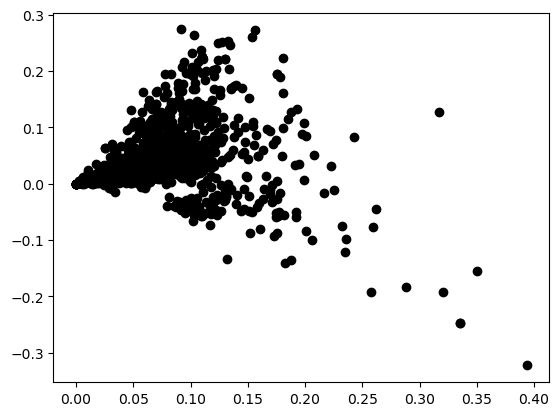

In [25]:
# Plot each category
plt.scatter(reduced_data.take(ix, axis=0)[:, :, 0], reduced_data.take(ix, axis=0)[:, :, 1], c="k")

(-0.6, 1.0)

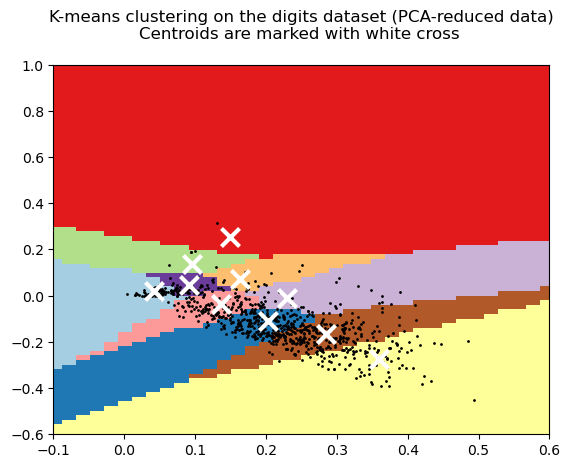

In [26]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# Plot each category
#plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c="k", s=1)

# Plot one category
ix = np.where(intent['negativereason'] == 7)
plt.scatter(reduced_data.take(ix, axis=0)[:, :, 0], reduced_data.take(ix, axis=0)[:, :, 1], c="k", s=1)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross \n"
)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.6, 1.0)

In [27]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [28]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=intent.negativereason)

# try with mini
minibatch_kmeans = MiniBatchKMeans(
    n_clusters=num_labels,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)
bench_k_means(kmeans=minibatch_kmeans, name="minibatch", data=X, labels=intent.negativereason)


#two_dim_tweets = PCA(n_components=2).fit(X)

# pca = PCA(n_components=num_labels).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=num_labels, n_init=1)
Xpca = TruncatedSVD(num_labels).fit(X)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based", data=X, labels=intent.negativereason)



minibatch_kmeans = MiniBatchKMeans(
    n_clusters=num_labels,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)
bench_k_means(kmeans=minibatch_kmeans, name="SVD-mini", data=X, labels=intent.negativereason)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.206s	8692	0.118	0.124	0.121	0.046	0.119	0.005
random   	0.092s	8701	0.110	0.135	0.121	0.021	0.119	0.007
minibatch	0.089s	8744	0.145	0.155	0.150	0.073	0.148	0.006
SVD-based	0.031s	8710	0.065	0.076	0.070	-0.015	0.068	0.002
SVD-mini 	0.069s	8677	0.147	0.147	0.147	0.049	0.145	0.006


In [29]:
print("K-means clustering for LSA dataset")
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X_lsa, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X_lsa, labels=intent.negativereason)

# pca = PCA(n_components=num_labels).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=num_labels, n_init=1)
Xpca = TruncatedSVD(num_labels).fit(X_lsa)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based", data=X_lsa, labels=intent.negativereason)

bench_k_means(kmeans=minibatch_kmeans, name="SVD-mini", data=X_lsa, labels=intent.negativereason)

K-means clustering for LSA dataset
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.354s	7508	0.126	0.126	0.126	0.042	0.124	0.043
random   	0.236s	7545	0.074	0.075	0.075	0.015	0.072	0.057
SVD-based	0.044s	7606	0.132	0.137	0.134	0.033	0.132	0.024
SVD-mini 	0.088s	7700	0.128	0.115	0.122	0.068	0.120	0.037


### Top Terms per cluster

In [30]:
# For printing terms in kmeans model trained on a reduced-dimension dataset, 
## need to use original, full tfidf embedding to reverse-translate back to original terms
def print_top_terms_svd(kmeans_model, X_tfidf):
    original_space_centroids = kmeans_model.cluster_centers_
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(num_labels):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

In [31]:
def print_top_terms(kmeans_model):
    original_space_centroids = kmeans_model.cluster_centers_
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(num_labels):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

In [32]:
kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=intent.negativereason)

print_top_terms(kmeans)

k-means++	0.196s	8692	0.118	0.124	0.121	0.046	0.119	0.009
Cluster 0: plane cannot get flight hours gate sitting help us still 
Cluster 1: time flight jetblue every wait departure first would airline last 
Cluster 2: service customer get bag help would one still airline worst 
Cluster 3: cancelled flightled flight flighted flights get hold tomorrow help hours 
Cluster 4: jetblue flight jfk delayed get delay us plane would service 
Cluster 5: call back get number someone cannot service help phone flight 
Cluster 6: hour waiting delay flight half plane gate sitting still wait 
Cluster 7: flight late delayed get hours gate us miss help hrs 
Cluster 8: hold hours minutes hour help min flight service customer trying 
Cluster 9: co http jetblue flight fleek fleet hold rt amp still 


In [33]:
bench_k_means(kmeans=minibatch_kmeans, name="SVD-mini", data=X, labels=intent.negativereason)

print_top_terms(minibatch_kmeans)

SVD-mini 	0.092s	8705	0.133	0.144	0.138	0.088	0.136	0.009
Cluster 0: jetblue flight delayed jfk delay time service get would us 
Cluster 1: service customer get call bag help time would one still 
Cluster 2: plane sitting flight us hours get hour waiting delay jetblue 
Cluster 3: flight delayed late hour hours get time delay change another 
Cluster 4: gate waiting agent flight still us hour plane agents crew 
Cluster 5: bags flight staff still waiting lost people help baggage min 
Cluster 6: cannot hold minutes get help call hours phone flight online 
Cluster 7: co http jetblue fleek flight fleet hold rt time still 
Cluster 8: cancelled flightled flight flighted flights tomorrow get hold today help 
Cluster 9: never fly ever flying airline service customer worst flight ticket 


In [34]:
kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X_lsa, labels=intent.negativereason)

print_top_terms(kmeans)

k-means++	0.769s	7508	0.126	0.126	0.126	0.042	0.124	0.033
Cluster 0: aa absolute abysmal accepted accept abc absolutely acceptable accepting account 
Cluster 1: aa abc absolute accept adding account accommodate advantage absurd advertise 
Cluster 2: aa absolutely absurd abysmal accountability advantage agent addressed afternoon aircanada 
Cluster 3: abysmal aa able absurd abc ac access across account adding 
Cluster 4: able absolutely abc aa accepted according ac accommodations added accurate 
Cluster 5: aa actual advisory abc absolute ahold ads absurd age airport 
Cluster 6: abc aa ac absolutely accepting accepted accommodate accountability actually abysmal 
Cluster 7: aa ac accept able access account accurate actual adding advertise 
Cluster 8: accounts aa actions actually accountability admirals address afternoon able absolute 
Cluster 9: aa absurd acceptable absolute accommodate access abc across ac act 


### Using UMAP for dimensionality reduction as pre-processing for clustering

In [35]:
import umap

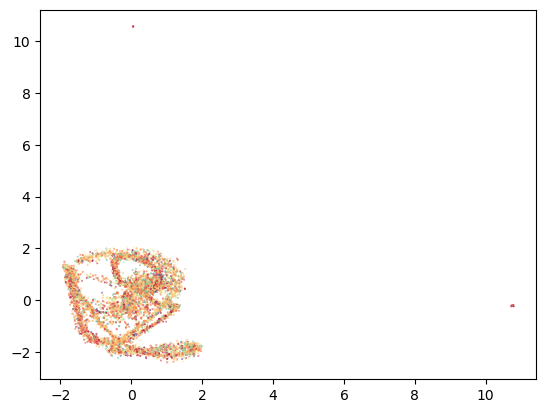

In [40]:
standard_embedding = umap.UMAP(random_state=1, n_components=10).fit_transform(X)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intent.negativereason, s=0.1, cmap='Spectral')

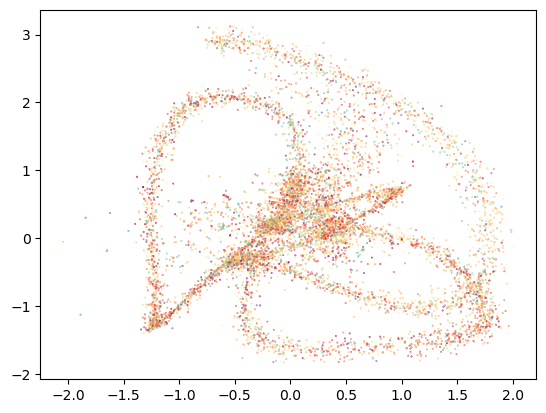

In [41]:
plt.scatter(standard_embedding[:, 2], standard_embedding[:, 3], c=intent.negativereason, s=0.1, cmap='Spectral')

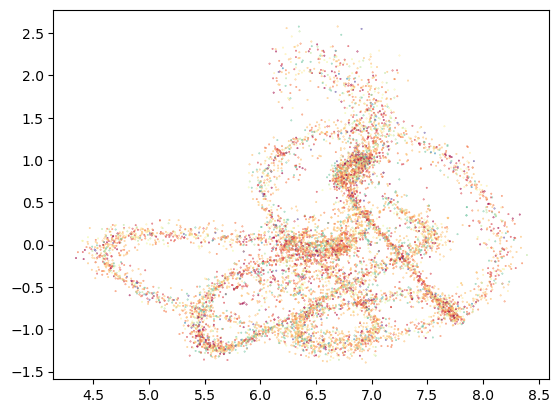

In [42]:
plt.scatter(standard_embedding[:, 4], standard_embedding[:, 5], c=intent.negativereason, s=0.1, cmap='Spectral')

In [46]:
print("K-means clustering for UMAP dataset, with n_components=10")
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ UMAP10", data=standard_embedding, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random UMAP10", data=standard_embedding, labels=intent.negativereason)

# pca = PCA(n_components=num_labels).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=num_labels, n_init=1)
Xpca = TruncatedSVD(num_labels).fit(standard_embedding)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based UMAP10", data=standard_embedding, labels=intent.negativereason)

bench_k_means(kmeans=minibatch_kmeans, name="SVD-mini UMAP10", data=standard_embedding, labels=intent.negativereason)

K-means clustering for UMAP dataset, with n_components=10
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ UMAP10	0.137s	26315	0.010	0.009	0.010	0.002	0.008	0.362
random UMAP10	0.101s	26387	0.010	0.009	0.009	0.002	0.007	0.385
SVD-based UMAP10	0.016s	45746	0.009	0.011	0.010	0.003	0.008	0.305
SVD-mini UMAP10	0.020s	28199	0.011	0.010	0.011	0.001	0.008	0.343


In [47]:
X_umap = umap.UMAP(random_state=1, n_components=100).fit_transform(X)

In [48]:
print("K-means clustering for UMAP dataset, n_componenets = 100")
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

X_umap = umap.UMAP(random_state=1, n_components=100).fit_transform(X)

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ UMAP10", data=X_umap, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random UMAP10", data=X_umap, labels=intent.negativereason)

Xpca = TruncatedSVD(num_labels).fit(X_umap)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based UMAP10", data=X_umap, labels=intent.negativereason)

bench_k_means(kmeans=minibatch_kmeans, name="SVD-mini UMAP10", data=X_umap, labels=intent.negativereason)

K-means clustering for UMAP dataset, n_componenets = 100
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ UMAP10	0.428s	26051	0.013	0.011	0.012	0.001	0.010	0.308
random UMAP10	0.370s	26186	0.011	0.010	0.011	0.001	0.009	0.385
SVD-based UMAP10	0.113s	26413	0.010	0.009	0.009	0.002	0.007	0.342
SVD-mini UMAP10	0.030s	27091	0.012	0.010	0.011	0.003	0.009	0.360
